# Bird Species Image Recognition
We are building a ML model using Tensorflow to recognise different bird species. This project is based on a [dataset](https://www.kaggle.com/gpiosenka/100-bird-species) from Kaggle.

The vision behind this project is to provide an excellent model for a bird tracking and counting app. This App could take advantage of bird enthusiast taken pictures. The taken pictures are classified by our model and a heatmap of different bird species could be created.

This notebook can take advantage of GPU Acceleration. Fortunatly Datalore provides a GPU instance with a Nvidia T4 GPU in it. This instance should be used for analysis, training and saving of the model. 
Further calculations and predictions using the trained model should use a smaller and slower instance to safe on computing time on the GPU instance.

The exported model is saved under "Attached Files". You can access them via the menu on the left side or via the console windows under tools.
In console you have to run the following command to get into the export directory `cd /data/notebook_files/export`.

To download the trained model just switch to "Attached Files" and download the provided ZIP file in the `export` directory. (ZIP not provided yet)

## Manual package installation
To use the save and export block without any errors you have to install some Python package manually. In Datalore you can use the package installer on the left site menu.

Packages:
- zipdir

# Creating, training and saving the model

## Import needed libraries
All libraries used in the first section of the notebook are imported here to unclutter following code blocks. 

**Therefore this block must be executed to gurantee flawless execution of the following code blocks.**

In [2]:
# Used for generating plots
import matplotlib.pyplot as plt
# Small math utility package
import numpy as np
# Tensorflow (library for ML)
import tensorflow as tf
# Small path and file interaction util package
import pathlib
# OS for file walking
import os

# Keras provides an easy to use interface for Tensorflow and is specifically made for neural networks
from tensorflow import keras
# A layer is the basic building block of a neural network in Keras
from tensorflow.keras import layers
# Sequential groups multiple layers into a Keras model
from tensorflow.keras.models import Sequential

## Download and prepare data archive
Before any computation can begin we have to download the choosen [dataset](https://www.kaggle.com/gpiosenka/100-bird-species) from Kaggle. The dataset is provided as a ZIP archive. To make use of the images contained inside the dataset we need to extract the ZIP archive.

For further use the path to the training and validation dataset is saved into a variable.

**If you use the original Kaggle link it is possible that the link expires after some time because it has an expire parameter in the URL**

In [2]:
dataset_url = "https://onedrive.live.com/download?cid=1D4188EA3D5DB234&resid=1D4188EA3D5DB234%2147165&authkey=AAyMv-YcCTKAAXw"
tf.keras.utils.get_file('archive', origin=dataset_url, extract=True)

# paths to datasets in variables for further use
training_ds_dir = pathlib.Path('/home/datalore/.keras/datasets/train')
validation_ds_dir = pathlib.Path('/home/datalore/.keras/datasets/valid')
test_ds_dir = pathlib.Path('/home/datalore/.keras/datasets/test')

932569088/932563464 [==============================] - 30s 0us/step


Now we can get some basic informations of the dataset.

In [3]:
print('=== Training dataset ===')
print('Category count (species):', len([element for element in training_ds_dir.iterdir() if element.is_dir()]))
print('Image count (images overall):', len(list(training_ds_dir.glob('**/*.jpg'))))

print('\n=== Validation dataset ===')
print('Category count (species):', len([element for element in validation_ds_dir.iterdir() if element.is_dir()]))
print('Image count (images overall):', len(list(validation_ds_dir.glob('**/*.jpg'))))

print('\n=== Test dataset ===')
print('Category count (species):', len([element for element in test_ds_dir.iterdir() if element.is_dir()]))
print('Image count (images overall):', len(list(test_ds_dir.glob('**/*.jpg'))))

=== Training dataset ===
Category count (species): 275
Image count (images overall): 39364

=== Validation dataset ===
Category count (species): 275
Image count (images overall): 1375

=== Test dataset ===
Category count (species): 275
Image count (images overall): 1375


## Load images into keras
The interface library Keras provides an easy way to load images into a TensorFlow dataset. We can do that using Keras preprocessing.
We are creating two datasets. The first one contains all classified training images and the other contains validation images for each class.

To safe memory Keras can load the images in batches into a dataset. How many images are loaded at the same can be defined using a variable.

For later use a variable containing all classnames gets created.

In [4]:
# Size of a batch the images get loaded in
batch_size = 32
# Image height
height = 224
# Image width
width = 224

# Load training images into the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_ds_dir,
    seed=123,                                                           
    image_size=(height, width),
    batch_size=batch_size)
# Load validation images into the validation dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_ds_dir,
    seed=123,
    image_size=(height, width),
    batch_size=batch_size)

# Array containing all classes
class_names = train_ds.class_names
print('\nClasses:', class_names)

Found 39364 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.

Classes: ['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN', 'ASIAN CRESTED IBIS', 'BALD EAGLE', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BANDED BROADBILL', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BEARDED REEDLING', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK & YELLOW bROADBILL', 'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK TAIL CRAKE', 'BLACK THROATED BUSHTIT', 'BLACK THROATED WARBLER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLUE GROUSE', 'BLUE HERON', 'BOBOLINK', 'BORNEAN BRISTLEHEAD', 'BORNEAN LEAF

## Visualize data
To give a small inspection in the dataset nine images are random selected and printed into the notebook.

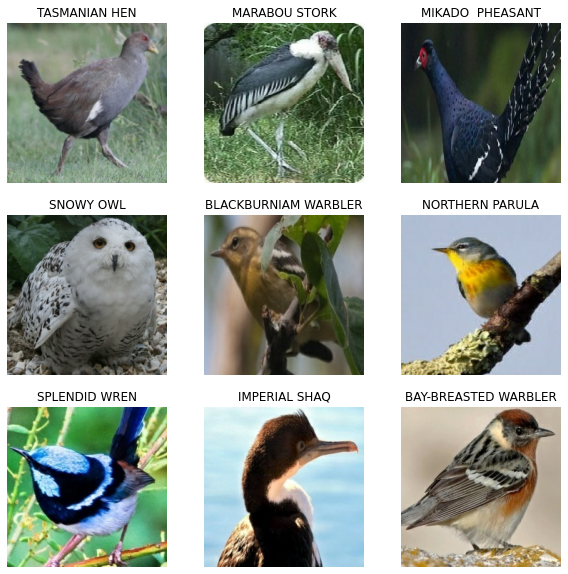

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Data Augmentation
Data Augementation is used to mitigate overfitting. With Data Augmentation images are slightly modified to get more training images.

In [6]:
train_ds_augmented = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(height, width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Display nine augmented images to show how augmentation works.

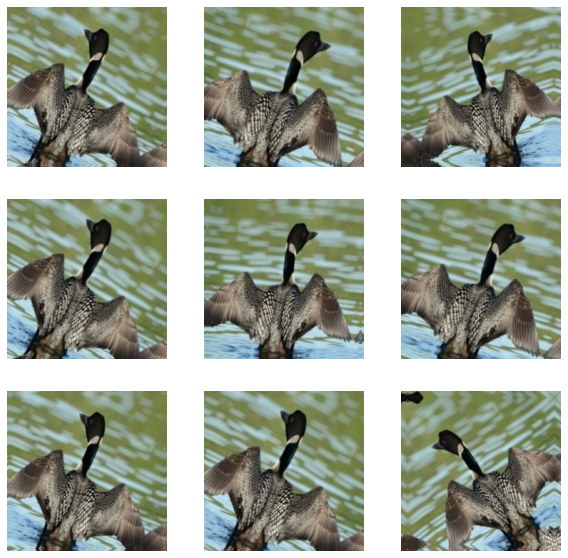

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = train_ds_augmented(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Create the model
A keras model consits of multiple layers. The Sequential object combines theses layers to a model.

*TBD: layer description*
### [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/)
* Extract features by applying filter (kernel) windows
* applied activation function: "rectified linear unit" (relu)

### [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
* reduces the Input along spatial dimensions by moving a 2x2 window over the image
* takes the highest of the four values in window

### [Dropout](https://keras.io/api/layers/regularization_layers/dropout/)
* used to prevent overfitting
* ignore randomly selected hidden layer neurons during training
* reduces co-dependency of neurons

### [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/)
* converts ("flattens") the data from two dimensions to one

### [Dense](https://keras.io/api/layers/core_layers/dense/)
* "deeply connected layer"
* performs the actual classification

In [8]:
num_classes = 275

model = Sequential([
  train_ds_augmented,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model
With compiling the model we are configuring it for training.

In [9]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## Model summary
Print all information of the model.

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

## Train the model
We define the amount of epochs and then train the model. A high amount of epochs increases the computation time but also increases the accuracy of the model until we are running into overfitting.

In [11]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 97/100
1231/1231 [==============================] - 70s 57ms/step - loss: 0.4253 - accuracy: 0.8756 - val_loss: 1.2935 - val_accuracy: 0.7745
Epoch 98/100
1231/1231 [==============================] - 71s 57ms/step - loss: 0.4481 - accuracy: 0.8690 - val_loss: 1.1632 - val_accuracy: 0.7869
Epoch 99/100
1231/1231 [==============================] - 71s 57ms/step - loss: 0.4528 - accuracy: 0.8692 - val_loss: 1.2532 - val_accuracy: 0.7782
Epoch 100/100
1231/1231 [==============================] - 71s 57ms/step - loss: 0.4332 - accuracy: 0.8744 - val_loss: 1.2210 - val_accuracy: 0.7825


## Visualize training results
To visualize our training results we are generating two plots. One containing the training accuracy and one for our loss values.
With this chart we can optimise the model.

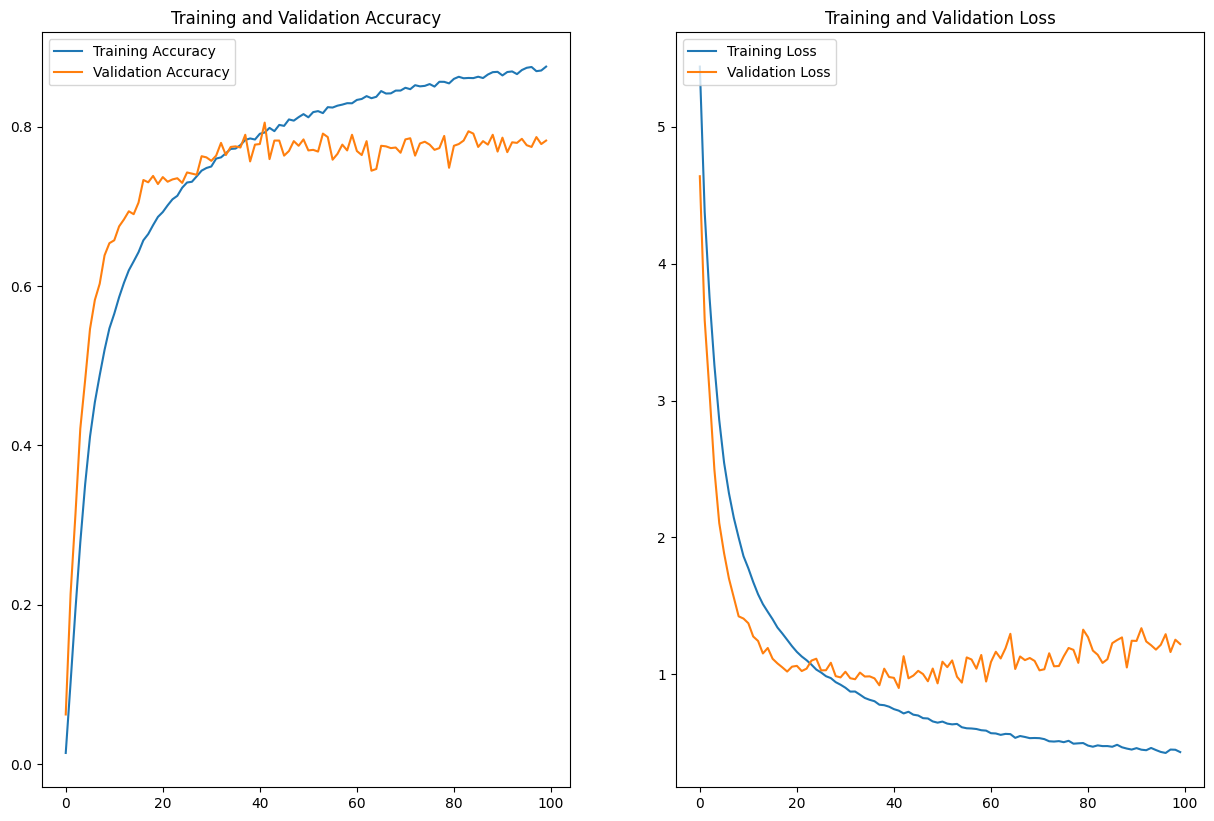

In [12]:
# Save accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Save loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Init figure for both plots
plt.figure(figsize=(15, 10), dpi=100)

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

# Show both plots
plt.show()

## Delete existing export
Delete the existing exported data to ensure that no data of the old model is mixed with the new one.

In [13]:
# Delete existing exported data
import shutil
shutil.rmtree('/data/notebook_files/export')

FileNotFoundError: FileNotFoundError: [Errno 2] No such file or directory: '/data/notebook_files/export'

## Export and zip model
Export the keras model into the export directory and zip it to simply downloading.

In [14]:
# Export keras model
pathlib.Path('/data/notebook_files/export/model').mkdir(parents=True, exist_ok=True)
model.save('/data/notebook_files/export/model')

# ZIP model directory to simplify download
import zipdir
zipdir.zipDirectory('/data/notebook_files/export/model', outputFile='/data/notebook_files/export/model.zip')

import pickle
with open('/data/notebook_files/export/history/history', 'wb') as file_pi:
    pickle.dump(history, file_pi)

INFO:tensorflow:Assets written to: /data/notebook_files/export/model/assets


# Predict on test dataset
**Starting with this block all following blocks should be executed on a smaller instance to save GPU computation time. The model can be loaded from disk.**

Load the exported model from disk into a keras model. After loading the model's summary is printed.

In [15]:
# Load model from file to save computation time
model = keras.models.load_model('/data/notebook_files/export/model')
model.summary()

KeyboardInterrupt: KeyboardInterrupt: 

## Predict a single image
Use the model to predict a single manually picked images.

In [16]:
# Init probably missing variables.
# The variables could be missing if we dont execute all steps above and start with loading the model from the disk.
height = 224
width = 224

# Load image with keras and expand it into a image batch
african_crowned_crane_path = pathlib.Path('/home/datalore/.keras/datasets/test/AFRICAN CROWNED CRANE/2.jpg')
img = keras.preprocessing.image.load_img(
    african_crowned_crane_path, target_size=(height, width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Predict the image
predictions = model.predict(img_array)
# Get confidence
score = tf.nn.softmax(predictions[0])

# Print confidence and predicted species
print(
      'This bird is most likely a {} with a {:.2f} percent confidence.'
      .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This bird is most likely a AFRICAN CROWNED CRANE with a 100.00 percent confidence.


## Predict all test images and analyze the accuracy
Now we can predict all images in the provided test dataset. The following code cell predicts all images and add the result to a confidence array. With this confidence array we can generate the nice little plot below the nect but one code cell.

In [17]:
# Init confidence array
confidence = [0] * len(class_names)

# Index must be -1 at start because os.walk starts with the root dir and not with the first subdir
index = -1
for directory, subdirectories, files in os.walk('/home/datalore/.keras/datasets/test/'):
    for file in files:
        # Load image with keras and expand it into a image batch
        img = keras.preprocessing.image.load_img(
            os.path.join(directory, file), target_size=(height, width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        # Predict the image
        predictions = model.predict(img_array)
        # Get confidence
        score = tf.nn.softmax(predictions[0])
        # Check if prediction is correct and add it to confidence array
        confidence[index] += (class_names[np.argmax(score)] == pathlib.PurePath(directory).name and 1 or 0)
    index += 1

In [12]:
# Setup plot that shows correctly predicted images as a bar chart
fig, ax = plt.subplots(1, 1, figsize=(20, 100))
y_pos = np.arange(len(class_names))
ax.barh(y_pos, np.flip(confidence), align='center', height=.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(class_names)
ax.invert_yaxis()
ax.set_xlabel('Images correctly categorized')
ax.set_title('How many images of each category are correctly predited?')
plt.ylim(min(y_pos)-1, max(y_pos)+1)
plt.savefig('/data/notebook_files/correctly_predicted.jpg')

# Show plot
plt.show()

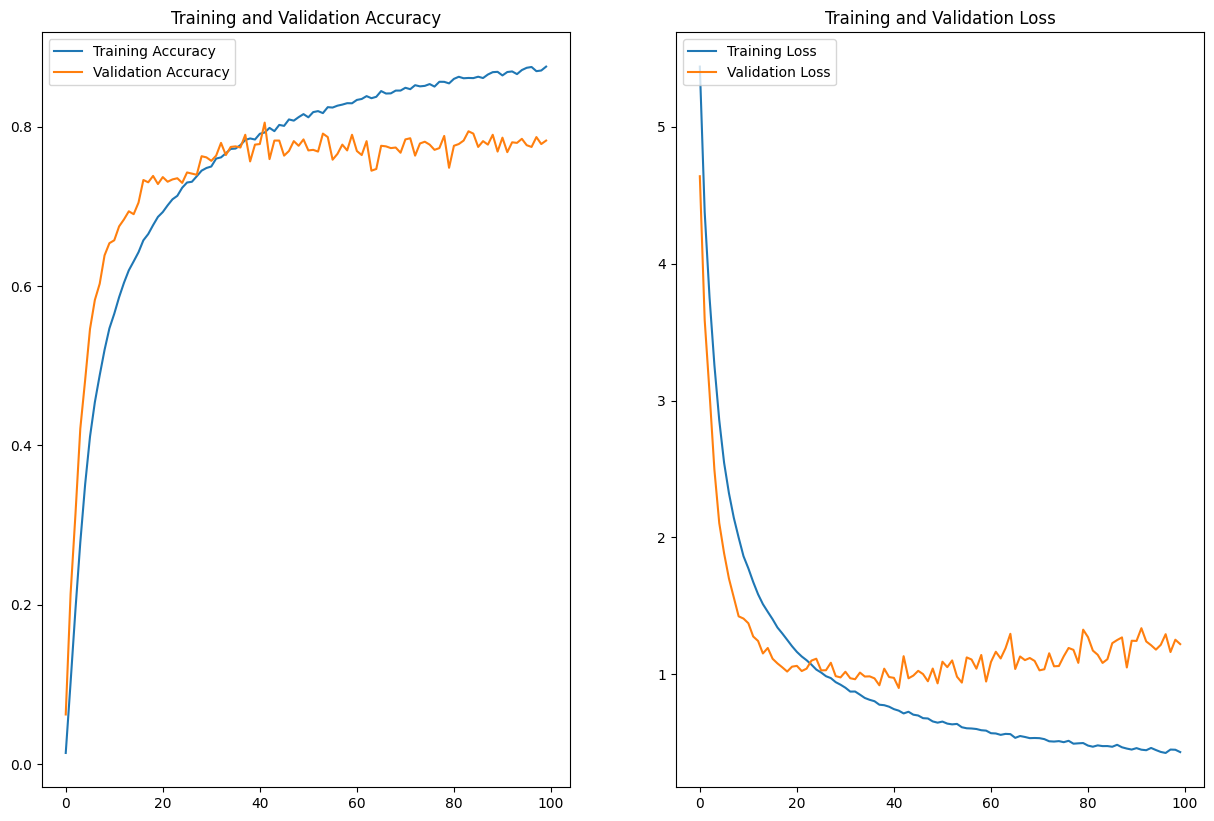

In [11]:
import pickle
history = pickle.load(open('/data/notebook_files/export/history/history', 'rb'))

# Save accuracy values
acc = history['accuracy']
val_acc = history['val_accuracy']

# Save loss values
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)

# Init figure for both plots
plt.figure(figsize=(15, 10), dpi=100)

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

# Show both plots
plt.show()
